<a href="https://colab.research.google.com/github/moushumipriya/Norway-Snowfall-Prediction-using-LSTM/blob/main/Norway_Snowfall_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Load and Preview Dataset

In [77]:
import pandas as pd


df = pd.read_csv("norway_snowfall_dataset.csv")

print(df.head())

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")


              datetime  temperature_C  humidity_%  pressure_hPa  \
0  2023-01-01 00:00:00       4.967142   73.783606   1014.215673   
1  2023-01-01 06:00:00      -1.382643   68.256564   1010.648983   
2  2023-01-01 12:00:00       6.476885   73.220698   1016.061661   
3  2023-01-01 18:00:00      10.000000   93.671771   1008.107058   
4  2023-01-02 00:00:00      -2.341534   84.781745   1006.092041   

   wind_speed_mps  visibility_m  snowfall_mm  
0        0.245409   7590.164604     0.000000  
1        2.313330   6101.639351     3.970119  
2        5.284415   3575.847239     0.000000  
3        5.314489   2938.255598     0.000000  
4        2.657009   5330.940602     1.048198  
Dataset shape: (2925, 7)
Columns: ['datetime', 'temperature_C', 'humidity_%', 'pressure_hPa', 'wind_speed_mps', 'visibility_m', 'snowfall_mm']


Data Preprocessing and Visualization

Check Missing Values and Data Summary

In [78]:

print(df.isnull().sum())

print(df.info())
print(df.describe())


datetime          0
temperature_C     0
humidity_%        0
pressure_hPa      0
wind_speed_mps    0
visibility_m      0
snowfall_mm       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925 entries, 0 to 2924
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datetime        2925 non-null   object 
 1   temperature_C   2925 non-null   float64
 2   humidity_%      2925 non-null   float64
 3   pressure_hPa    2925 non-null   float64
 4   wind_speed_mps  2925 non-null   float64
 5   visibility_m    2925 non-null   float64
 6   snowfall_mm     2925 non-null   float64
dtypes: float64(6), object(1)
memory usage: 160.1+ KB
None
       temperature_C   humidity_%  pressure_hPa  wind_speed_mps  visibility_m  \
count    2925.000000  2925.000000   2925.000000     2925.000000   2925.000000   
mean       -0.552664    69.358891   1013.008506        3.073752   5460.231344   
std         8.440785    14.774025 

Plot Temperature and Snowfall Trends Over Time


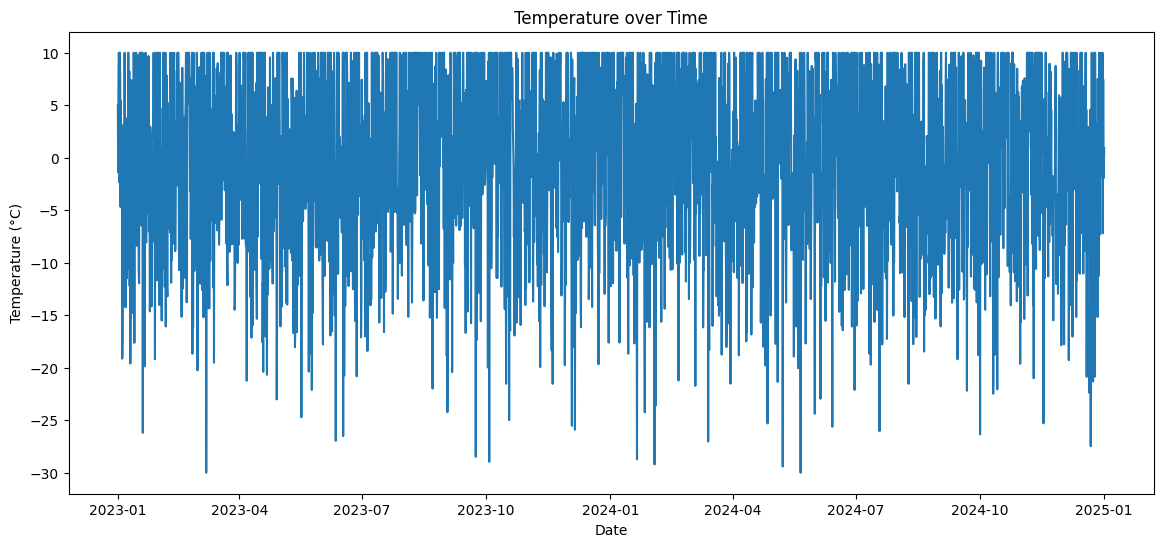

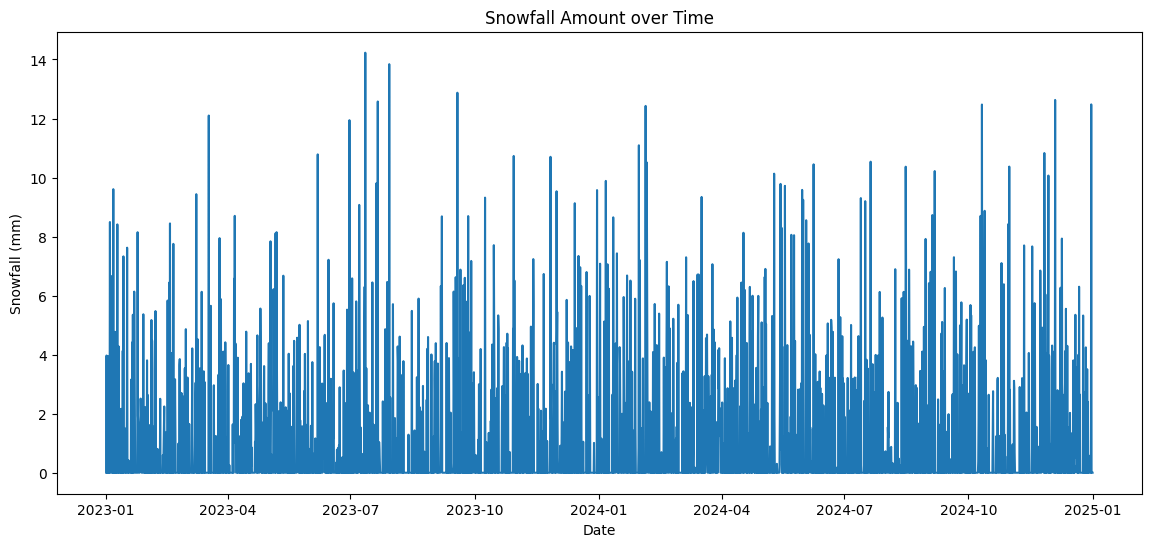

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'datetime' column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Temperature over time plot
plt.figure(figsize=(14,6))
sns.lineplot(x='datetime', y='temperature_C', data=df)
plt.title('Temperature over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

# Snowfall over time plot
plt.figure(figsize=(14,6))
sns.lineplot(x='datetime', y='snowfall_mm', data=df)
plt.title('Snowfall Amount over Time')
plt.xlabel('Date')
plt.ylabel('Snowfall (mm)')
plt.show()


 Feature Engineering

 Extract datetime features

In [80]:
# Extract useful features from datetime
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek


Create lag features

In [81]:
df['lag_1'] = df['snowfall_mm'].shift(1)
df['lag_2'] = df['snowfall_mm'].shift(2)
df['lag_3'] = df['snowfall_mm'].shift(3)


Drop rows with NaN (due to lagging)

In [82]:
df = df.dropna()


Final feature columns to use

In [83]:
features = ['temperature_C', 'humidity_%', 'pressure_hPa', 'wind_speed_mps', 'year', 'month', 'day', 'hour', 'dayofweek', 'lag_1', 'lag_2', 'lag_3']
target = 'snowfall_mm'

 Train-Test Split

 Define split ratio and split

In [84]:
# Define train size (e.g., 80%)
train_size = int(len(df) * 0.8)

# Split features and target
X = df[features]
y = df[target]

# Train and test split
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (2337, 12), Test shape: (585, 12)


 Scale features

In [85]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_y = StandardScaler() # Scaler for target variable

# Fit on train and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale the target variable
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

Build and Train LSTM Model
LSTM (Long Short-Term Memory) is perfect for time series forecasting as it learns temporal dependencies.



 Reshape input for LSTM

In [86]:
# Reshape input to be 3D for LSTM [samples, timesteps, features]
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print("LSTM input shape:", X_train_lstm.shape)

LSTM input shape: (2337, 1, 12)


Build the model

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,825 (85.25 KB)

 Trainable params: 21,825 (85.25 KB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [88]:
history = model.fit(
    X_train_lstm, y_train_scaled, # Use scaled target variable
    validation_data=(X_test_lstm, y_test_scaled), # Use scaled target variable
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.9937 - mae: 0.6930 - val_loss: 0.8930 - val_mae: 0.5778
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7137 - mae: 0.5360 - val_loss: 0.8251 - val_mae: 0.5440
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6859 - mae: 0.4981 - val_loss: 0.8066 - val_mae: 0.5302
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6364 - mae: 0.4952 - val_loss: 0.7862 - val_mae: 0.5208
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6617 - mae: 0.4971 - val_loss: 0.7806 - val_mae: 0.5147
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6212 - mae: 0.4851 - val_loss: 0.7725 - val_mae: 0.5237
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5856 - mae: 0.4837 - val_loss: 0.7618 - val_mae: 0.5207
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6777 - mae: 0.5084 - val_loss: 0.7655 - val_mae: 0.5148
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6045 - mae: 

Plot training history

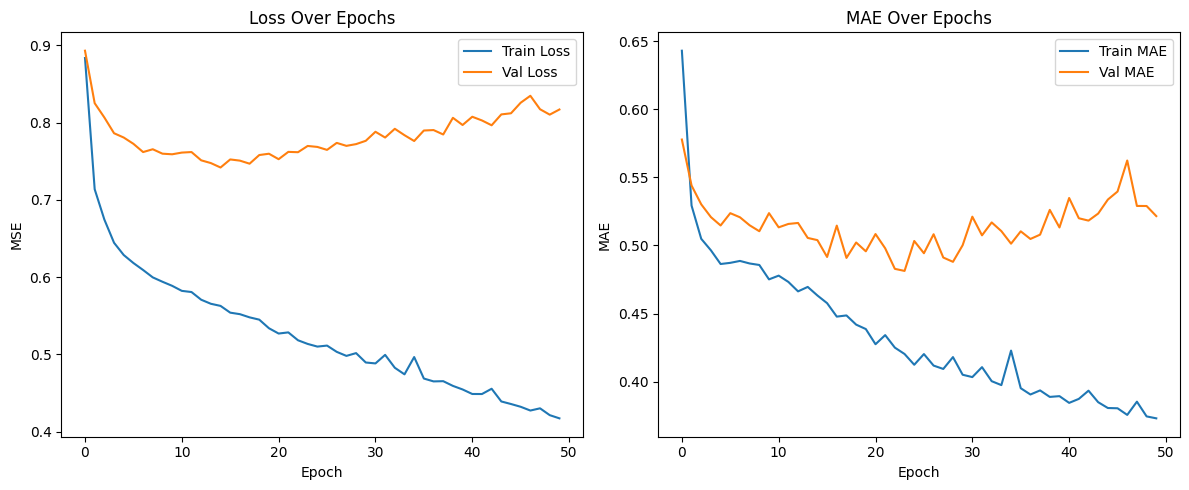

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


 Make Predictions and Evaluate Performance


 Predict on Test Set

In [90]:
# Make predictions
y_pred = model.predict(X_test_lstm)

# Reverse scaling
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Inverse transform predictions and actual values
y_pred_inverse = scaler_y.inverse_transform(y_pred) # Use scaler_y
y_test_inverse = scaler_y.inverse_transform(y_test_scaled) # Use scaled target variable for inverse transform

# Calculate performance metrics
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
rmse = mse**0.5
r2 = r2_score(y_test_inverse, y_pred_inverse)

print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE:  1.09
MSE:  3.57
RMSE: 1.89
R²:   0.2748


Plot Actual vs Predicted Snowfall

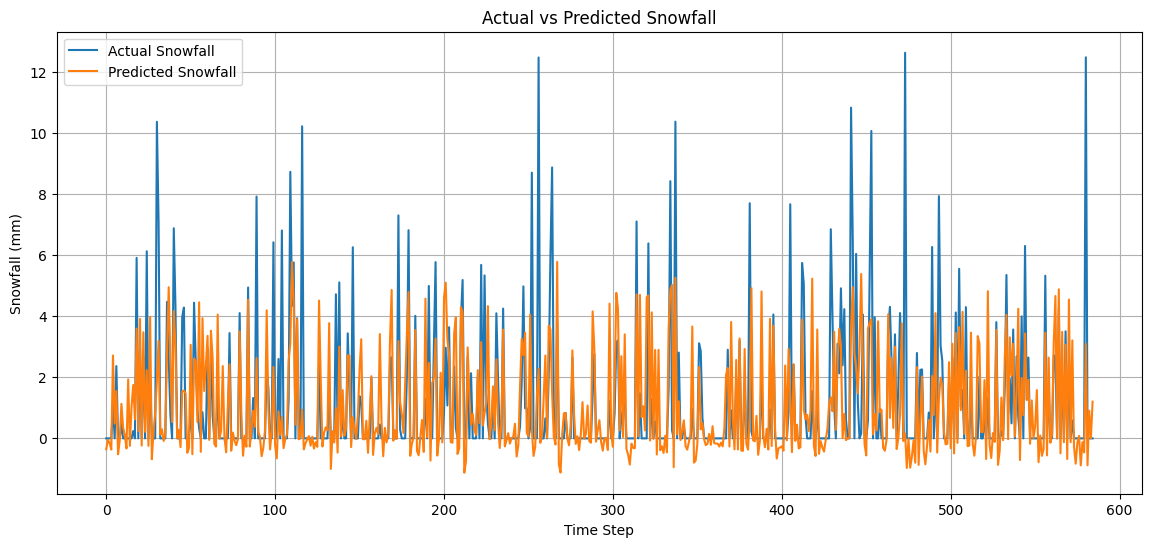

In [91]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_inverse, label='Actual Snowfall')
plt.plot(y_pred_inverse, label='Predicted Snowfall')
plt.title('Actual vs Predicted Snowfall')
plt.xlabel('Time Step')
plt.ylabel('Snowfall (mm)')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipython-input-2455752909.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_avg.index, y=month_avg.values, palette="coolwarm")
/tmp/ipython-input-2455752909.py:17: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


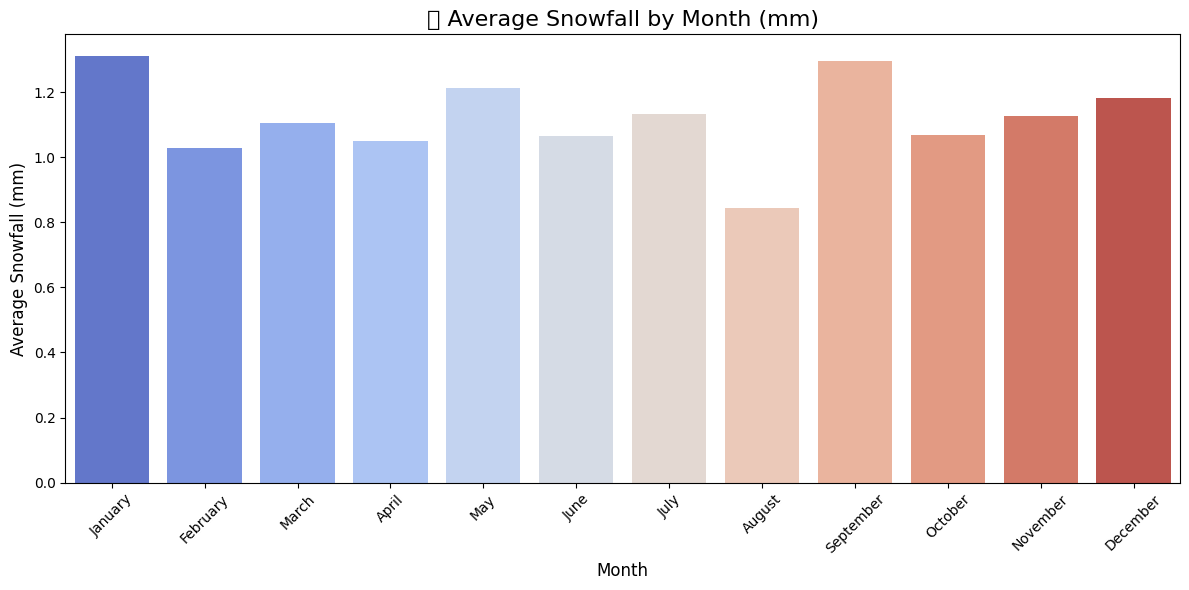

In [92]:

df['datetime'] = pd.to_datetime(df['datetime'])
df['Month'] = df['datetime'].dt.month_name()

# Group by Month
month_avg = df.groupby("Month")["snowfall_mm"].mean().reindex([
    'January','February','March','April','May','June',
    'July','August','September','October','November','December'
])

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=month_avg.index, y=month_avg.values, palette="coolwarm")
plt.title("📅 Average Snowfall by Month (mm)", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Snowfall (mm)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Predict Next 7 Days of Snowfall


In [95]:
# Import necessary libraries
import numpy as np

# Use the last sequence from test data as the seed input
# Get the last row using .iloc[-1] and convert to numpy array
last_sequence = X_test.iloc[-1].values.copy() # Use .copy() to avoid SettingWithCopyWarning

# Define time_steps based on the number of features
time_steps = 1  # Since we are using a single time step for each prediction

# Store predictions
future_predictions = []

# Create a copy of the last actual observation to use as the base for future predictions
current_input_features = last_sequence.copy()


for _ in range(7):
    # Scale the current input features
    current_input_scaled = scaler.transform(current_input_features.reshape(1, -1))

    # Reshape to (1, time_steps, features) to feed into the model
    current_input_lstm = current_input_scaled.reshape(1, time_steps, len(features))

    # Make prediction
    next_pred_scaled = model.predict(current_input_lstm)[0][0]

    # Inverse transform to get real snowfall value
    next_pred_real = scaler_y.inverse_transform(np.array(next_pred_scaled).reshape(-1, 1))[0][0]
    future_predictions.append(next_pred_real)

    # Prepare the input for the next prediction
    # For a single time step model, the next input will be the last actual observation
    # with the predicted snowfall replacing the actual snowfall.
    # Update the 'lag' features based on the new prediction.
    current_input_features[features.index('lag_3')] = current_input_features[features.index('lag_2')]
    current_input_features[features.index('lag_2')] = current_input_features[features.index('lag_1')]
    current_input_features[features.index('lag_1')] = next_pred_real

    # We don't have future actual values for other features, so we will keep them as they are from the last observation.
    # In a real-world scenario, you would need to forecast these features as well or use their known future values.


# Print results
print("📅 Predicted Snowfall for Next 7 Days (in mm):")
for i, value in enumerate(future_predictions, 1):
    print(f"Day {i}: {value:.2f} mm")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
📅 Predicted Snowfall for Next 7 Days (in mm):
Day 1: 1.20 mm
Day 2: 1.03 mm
Day 3: 0.78 mm
Day 4: 0.91 mm
Day 5: 0.93 mm
Day 6: 0.90 mm
Day 7: 0.90 mm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Plot the 7-Day Forecast

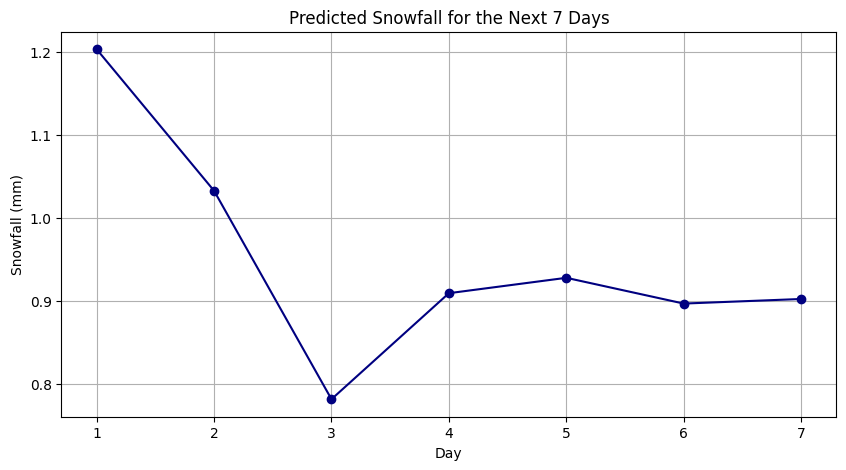

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, 8), future_predictions, marker='o', color='navy') # Corrected variable name
plt.title("Predicted Snowfall for the Next 7 Days")
plt.xlabel("Day")
plt.ylabel("Snowfall (mm)")
plt.grid(True)
plt.xticks(range(1, 8))
plt.show()